# train Focused Scene Text and Born Digital Images

In [1]:
import sys
sys.path.append('../')

%load_ext autoreload
%autoreload 2

from text_data import datasets, target_transforms, transforms, augmentations
from text_data.utils import batch_ind_fn_droptexts

from textboxespp.models.textboxespp import TextBoxesPP
from ssd.train import *
from textboxespp.train.loss import TextBoxLoss, ConfidenceLoss

#from torchvision import transforms > not import!!
from torch.utils.data import DataLoader
from torch.optim.adam import Adam
import torch

%matplotlib notebook
import matplotlib.pyplot as plt

In [2]:
augmentation = augmentations.RandomSampled()
#augmentation = None

transform = transforms.Compose(
    [transforms.Resize((384, 384)),
     transforms.ToTensor(),
     transforms.Normalize(rgb_means=(0.485, 0.456, 0.406), rgb_stds=(0.229, 0.224, 0.225))]
)
target_transform = target_transforms.Compose(
    [target_transforms.Corners2Centroids(),
     #target_transforms.ToQuadrilateral(),
     target_transforms.OneHot(class_nums=datasets.SynthText_class_nums, add_background=True),
     target_transforms.ToTensor()]
)

train_dataset = datasets.Compose((datasets.ICDARFocusedSceneTextDataset, datasets.ICDARBornDigitalTextDataset),
                                 ignore=None, transform=transform, target_transform=target_transform, augmentation=augmentation)

train_loader = DataLoader(train_dataset,
                          batch_size=32,
                          shuffle=True,
                          collate_fn=batch_ind_fn_droptexts,
                          num_workers=4,
                          pin_memory=True)

In [3]:
model = TextBoxesPP(input_shape=(384, 384, 3)).cuda()
model.load_weights('../weights/results/icdar2015/train-icdar2015-stage2-batch16_i-16000.pth')
print(model)

TextBoxesPP(
  (codec): TextBoxCodec(
    (encoder): TextBoxEncoder()
    (decoder): TextBoxDecoder()
  )
  (defaultBox): DBoxTextBoxOriginal()
  (predictor): TextBoxPredictor()
  (inferenceBox): InferenceBox()
  (feature_layers): ModuleDict(
    (convRL1_1): ConvRelu(
      (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): ReLU(inplace=True)
    )
    (convRL1_2): ConvRelu(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): ReLU(inplace=True)
    )
    (pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (convRL2_1): ConvRelu(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): ReLU(inplace=True)
    )
    (convRL2_2): ConvRelu(
      (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): ReLU(inplace=True)
    )
    (pool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dila

<IPython.core.display.Javascript object>


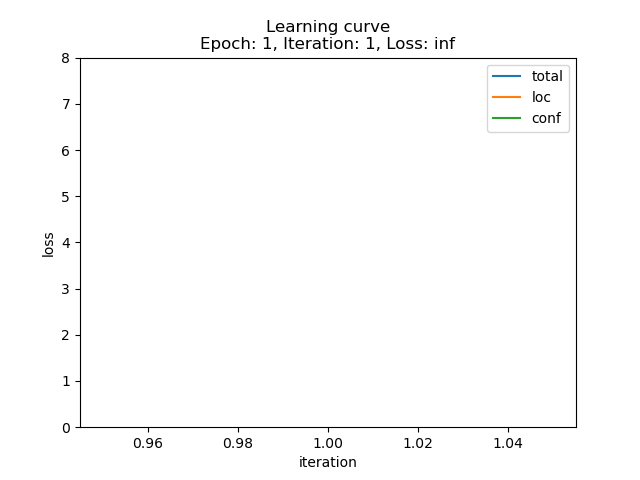

../textboxespp/core/boxes/utils.py:125: RuntimeWarning: invalid value encountered in true_divide
  return intersectionArea / A
../textboxespp/core/boxes/utils.py:125: RuntimeWarning: invalid value encountered in true_divide
  return intersectionArea / A


Training... Epoch: 1, Iter: 2,	 [64/639	 (10%)]	Loss: inf, Loc Loss: inf, Conf Loss: 5.554862	Iter time: 0.6595

error: Caught error in DataLoader worker process 2.
Original Traceback (most recent call last):
  File "/home/kado/.pyenv/versions/anaconda3-2019.07/envs/textbox/lib/python3.6/site-packages/torch/utils/data/_utils/worker.py", line 178, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/kado/.pyenv/versions/anaconda3-2019.07/envs/textbox/lib/python3.6/site-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/kado/.pyenv/versions/anaconda3-2019.07/envs/textbox/lib/python3.6/site-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/kado/.pyenv/versions/anaconda3-2019.07/envs/textbox/lib/python3.6/site-packages/ssd_data/datasets/base.py", line 188, in __getitem__
    return self.datasets[i][index - sum(self.lens[:i])]
  File "../text_data/datasets/base.py", line 18, in __getitem__
    img = self._get_image(index)
  File "../text_data/datasets/icdar.py", line 74, in _get_image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
cv2.error: OpenCV(4.2.0) ../modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'



In [4]:
optimizer = Adam(model.parameters(), lr=5e-5, weight_decay=5e-4)
# iter_sheduler = SSDIterMultiStepLR(optimizer, milestones=(10, 20, 30), gamma=0.1, verbose=True)
# iter_sheduler = SSDIterStepLR(optimizer, step_size=60000, gamma=0.1, verbose=True)

save_manager = SaveManager(modelname='train-icdar2015-stage1', interval=1000, max_checkpoints=15, savedir='../weights/')
log_manager = LogManager(interval=10, save_manager=save_manager, loss_interval=10, live_graph=LiveGraph((0, 8)))
trainer = TrainLogger(model, loss_func=TextBoxLoss(alpha=0.2, conf_loss=ConfidenceLoss(neg_factor=3)), optimizer=optimizer, scheduler=None,
                      log_manager=log_manager)

trainer.train(6000, train_loader)  # , evaluator=VOC2007Evaluator(val_dataset, iteration_interval=10))


In [1]:
import sys
sys.path.append('../')

%load_ext autoreload
%autoreload 2

from text_data import datasets, target_transforms, transforms, augmentations
from text_data.utils import batch_ind_fn_droptexts

from textboxespp.models.textboxespp import TextBoxesPP
from ssd.train import *
from textboxespp.train.loss import TextBoxLoss, ConfidenceLoss

#from torchvision import transforms > not import!!
from torch.utils.data import DataLoader
from torch.optim.adam import Adam
import torch

%matplotlib notebook
import matplotlib.pyplot as plt

In [2]:
augmentation = augmentations.RandomSampled()
#augmentation = None

transform = transforms.Compose(
    [transforms.Resize((768, 768)),
     transforms.ToTensor(),
     transforms.Normalize(rgb_means=(0.485, 0.456, 0.406), rgb_stds=(0.229, 0.224, 0.225))]
)
target_transform = target_transforms.Compose(
    [target_transforms.Corners2Centroids(),
     #target_transforms.ToQuadrilateral(),
     target_transforms.OneHot(class_nums=datasets.SynthText_class_nums, add_background=True),
     target_transforms.ToTensor()]
)

train_dataset = datasets.Compose((datasets.ICDARFocusedSceneTextDataset, datasets.ICDARBornDigitalTextDataset),
                                 ignore=None, transform=transform, target_transform=target_transform, augmentation=augmentation)

train_loader = DataLoader(train_dataset,
                          batch_size=8,
                          shuffle=True,
                          collate_fn=batch_ind_fn_droptexts,
                          num_workers=4,
                          pin_memory=True)

In [3]:
model = TextBoxesPP(input_shape=(768, 768, 3)).cuda()
model.load_weights('../weights/results/icdar2015/train-icdar2015-stage1_i-8000.pth')

<IPython.core.display.Javascript object>


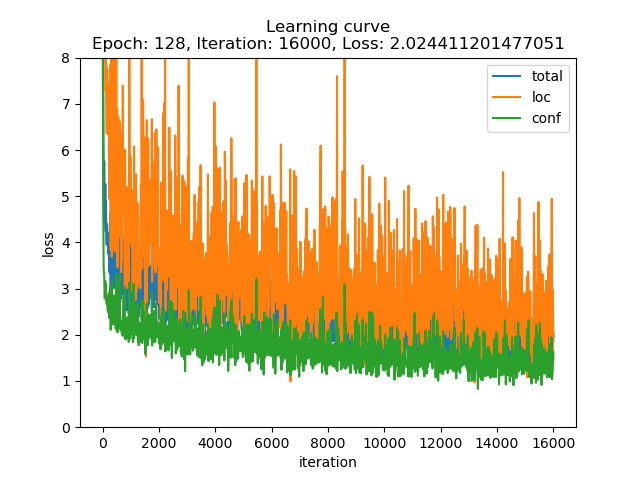

Training... Epoch: 8, Iter: 1000,	 [1000/1000	 (100%)]	Loss: 3.385427, Loc Loss: 4.885148, Conf Loss: 2.408398	Iter time: 0.3600
Saved model to ../weights/checkpoints/train-icdar2015-stage2-batch16_i-0001000_checkpoints20200617.pth

Training... Epoch: 16, Iter: 2000,	 [1000/1000	 (100%)]	Loss: 2.354117, Loc Loss: 2.696239, Conf Loss: 1.814869	Iter time: 0.3652
Saved model to ../weights/checkpoints/train-icdar2015-stage2-batch16_i-0002000_checkpoints20200617.pth

Training... Epoch: 24, Iter: 3000,	 [1000/1000	 (100%)]	Loss: 2.342074, Loc Loss: 3.318847, Conf Loss: 1.678305	Iter time: 0.4095
Saved model to ../weights/checkpoints/train-icdar2015-stage2-batch16_i-0003000_checkpoints20200617.pth

Training... Epoch: 32, Iter: 4000,	 [1000/1000	 (100%)]	Loss: 2.131476, Loc Loss: 2.654154, Conf Loss: 1.600645	Iter time: 0.3680
Saved model to ../weights/checkpoints/train-icdar2015-stage2-batch16_i-0004000_checkpoints20200617.pth

Training... Epoch: 40, Iter: 5000,	 [1000/1000	 (100%)]	Loss: 2.0

<IPython.core.display.Javascript object>


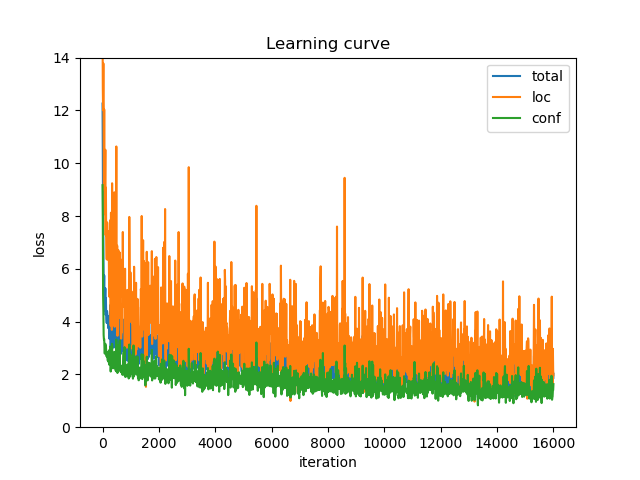

Saved graph to ../weights/results/train-icdar2015-stage2-batch16_learning-curve_i-16000.png


In [4]:
optimizer = Adam(model.parameters(), lr=1e-5, weight_decay=5e-4)
# iter_sheduler = SSDIterMultiStepLR(optimizer, milestones=(10, 20, 30), gamma=0.1, verbose=True)
# iter_sheduler = SSDIterStepLR(optimizer, step_size=60000, gamma=0.1, verbose=True)

save_manager = SaveManager(modelname='train-icdar2015-stage2-batch16', interval=1000, max_checkpoints=15, savedir='../weights/')
log_manager = LogManager(interval=10, save_manager=save_manager, loss_interval=10, live_graph=LiveGraph((0, 8)))
trainer = TrainLogger(model, loss_func=TextBoxLoss(alpha=0.2, conf_loss=ConfidenceLoss(neg_factor=6)), optimizer=optimizer, scheduler=None,
                      log_manager=log_manager)

trainer.train(14000, train_loader)  # , evaluator=VOC2007Evaluator(val_dataset, iteration_interval=10))
